In [1]:
import os
import torch
import torchvision
from d2l import torch as d2l

In [13]:
import hashlib
import requests
import zipfile
import tarfile
import os
import pandas as pd
import torchvision
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'


# Defined in file: ./chapter_multilayer-perceptrons/kaggle-house-price.md
def download(name, cache_dir=os.path.join('.', 'data2')):
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name, folder=None):
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

In [14]:
DATA_HUB['voc2012'] = (DATA_URL + 'VOCtrainval_11-May-2012.tar', '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')
voc_dir = download_extract('voc2012', 'VOCdevkit/VOC2012')

ReadError: file could not be opened successfully

不要在意上面的下载失败，我感觉可能是我的电脑问题，因为我用服务器可以正常下载，所以我用xftp又从服务器传到本地了，数据集的目录介绍如下图所示：
VOCdevkit
    └── VOC2012
         ├── Annotations               所有的图像标注信息(XML文件)
         ├── ImageSets
         │   ├── Action                人的行为动作图像信息
         │   ├── Layout                人的各个部位图像信息
         │   │
         │   ├── Main                  目标检测分类图像信息
         │   │     ├── train.txt       训练集(5717)
         │   │     ├── val.txt         验证集(5823)
         │   │     └── trainval.txt    训练集+验证集(11540)
         │   │
         │   └── Segmentation          目标分割图像信息
         │         ├── train.txt       训练集(1464)
         │         ├── val.txt         验证集(1449)
         │         └── trainval.txt    训练集+验证集(2913)
         │
         ├── JPEGImages                所有图像文件
         ├── SegmentationClass         语义分割png图（基于类别）
         └── SegmentationObject        实例分割png图（基于目标）


注意：labels原来是单通道的，所以这里得给它变成3通道

In [16]:
def read_voc_images(voc_dir, is_train=True):
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation', 'train.txt' if is_train else 'val.txt')
    mode = torchvision.io.image.ImageReadMode.RGB
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    for i, fname in enumerate(images):
        features.append(torchvision.io.read_image(os.path.join(voc_dir, 'JPEGImages', f'{fname}.jpg')))
        labels.append(torchvision.io.read_image(os.path.join(voc_dir, 'SegmentationClass', f'{fname}.png'), mode))
    return features, labels

train_features, train_labels = read_voc_images(voc_dir, is_train=True)

下面我们绘制前5个输入图像及其标签。 在标签图像中，白色和黑色分别表示边框和背景，而其他颜色则对应不同的类别。

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001F29C5DD198>,
      dtype=object)

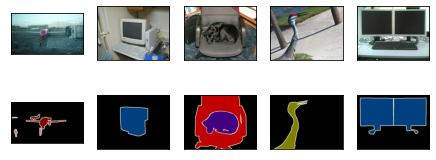

In [17]:
n = 5
imgs = train_features[0: n] + train_labels[0: n]
imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs, 2, n)

接下来，我们列举RGB颜色值和类名。

In [23]:
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

通过上面定义的两个常量，我们可以方便地查找标签中每个像素的类索引。 我们定义了voc_colormap2label函数来构建从上述RGB颜色值到类别索引的映射，而voc_label_indices函数将RGB值映射到在Pascal VOC2012数据集中的类别索引。

In [31]:
def voc_colormap2label():
    # 这个函数的作用就是创建一个长度为256^3的向量，保存从RGB的值对应的特定的算法对应的类别标签
    # 如按照上面的例子[0, 0, 0]对应0，[128, 0, 0]对应1，[0，128，0]对应2，这样方便我们后面进行其它操作
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
    return colormap2label

def voc_label_indices(colormap, colormap2label):
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256 + colormap[:, :, 2])
    return colormap2label[idx]

In [32]:
# 例如，在第一张样本图像中，飞机头部区域的类别索引为1，而背景索引为0。
y = voc_label_indices(train_labels[0], voc_colormap2label())
# y就是一个hxw的矩阵，每个值代表VOC_CLASSES中类别的索引
print(y.shape)
y[105:115, 130:140]

torch.Size([281, 500])


tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]])

torchvision.transforms.functional.crop() 方法用于在图像上执行裁剪操作，它需要以下参数：
img (PIL Image or Tensor): 要进行裁剪操作的图像，可以是 PIL Image 格式或者 PyTorch Tensor 格式。
top (int): 矩形区域左上角的垂直坐标（y 轴方向），即裁剪区域的顶部边界位置。
left (int): 矩形区域左上角的水平坐标（x 轴方向），即裁剪区域的左侧边界位置。
height (int): 裁剪区域的高度。
width (int): 裁剪区域的宽度
所以我们首先通过torchvision.transforms.RandomCrop.get_params()方法获取该方法所需要的参数

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001F2FA7894A8>,
      dtype=object)

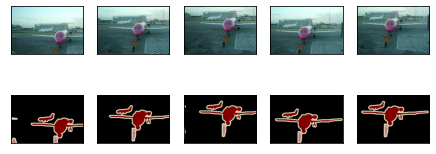

In [33]:
def voc_rand_crop(feature, label, height, width):
    rect = torchvision.transforms.RandomCrop.get_params(feature, (height, width))
    feature = torchvision.transforms.functional.crop(feature, *rect)
    label = torchvision.transforms.functional.crop(label, *rect)
    return feature, label

imgs = []
# 针对train_features和train_labels当中的第一个图像连续随机裁剪5次
for _ in range(n):
    # 注意，这里的+=不能改为.append，因为voc_rand_crop函数返回了两个元素，+=是将它们一个个加到列表imgs当中去，而.append会将它们作为一个元组加到imgs列表当中去
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)

imgs = [img.permute(1, 2, 0) for img in imgs]
# 选取步长为2，即将裁剪后的feature和label分开，先展示feature再展示label
d2l.show_images(imgs[::2] + imgs[1::2], 2, n)

我们通过继承高级API提供的Dataset类，自定义了一个语义分割数据集类VOCSegDataset。 通过实现__getitem__函数，我们可以任意访问数据集中索引为idx的输入图像及其每个像素的类别索引。 由于数据集中有些图像的尺寸可能小于随机裁剪所指定的输出尺寸，这些样本可以通过自定义的filter函数移除掉。 此外，我们还定义了normalize_image函数，从而对输入图像的RGB三个通道的值分别做标准化。

In [38]:
class VOCSegDataset(torch.utils.data.Dataset):
    def __init__(self, is_train, crop_size, voc_dir):
        self.transform = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature) for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = voc_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')

    def normalize_image(self, img):
        return self.transform(img.float() / 255)

    def filter(self, imgs):
        return [img for img in imgs if (img.shape[1] >= self.crop_size[0] and img.shape[2] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx], *self.crop_size)
        return (feature, voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

In [39]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples
read 1078 examples


In [45]:
batch_size = 64
train_iter = torch.utils.data.DataLoader(voc_train, batch_size, shuffle=True, drop_last=True, num_workers=d2l.get_dataloader_workers())

In [46]:
def load_data_voc(batch_size, crop_size):
    voc_dir = download_extract('voc2012', os.path.join(
        'VOCdevkit', 'VOC2012'))
    num_workers = d2l.get_dataloader_workers()
    train_iter = torch.utils.data.DataLoader(VOCSegDataset(True, crop_size, voc_dir), batch_size, shuffle=True,
                                             drop_last=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(VOCSegDataset(False, crop_size, voc_dir), batch_size,
                                             drop_last=True, num_workers=num_workers)
    return train_iter, test_iter